In [135]:
import tarfile
import pandas as pd
import torch
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from collections import Counter
import spacy
import os
import torch.optim as optim
import re
import contractions
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
train_parquet = '/Users/colinjohnson/Documents/code/GitHub/DS-5110/train_data.parquet'
test_parquet = '/Users/colinjohnson/Documents/code/GitHub/DS-5110/test_data.parquet'
vocab_file = '/Users/colinjohnson/Documents/code/GitHub/DS-5110/aclImdb/imdb.vocab'

df_test = pd.read_parquet(test_parquet, engine='pyarrow') 
df_train = pd.read_parquet(train_parquet, engine='pyarrow')

In [136]:
'''
Find vocab file and create a dictionary of all the words
'''

vocab = {}
with open(vocab_file, 'r',encoding='latin-1') as file:
    for idx, line in enumerate(file, start=1): 
        word = line.strip()  
        vocab[word] = idx

In [137]:
'''
Preprocess data removing tags, lemmanizing the data

'''

nlp = spacy.load('en_core_web_sm')
def remove_html_tags(text):
    return re.sub(r"<.*?>", "", text)
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)
def spacy_lemmatization(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc]
def filter_vocab(vocab, words_remove):
    #filter, function applied in tokenizing the vocab
    return {word for word in vocab if word not in words_remove}
def tokenize_with_vocab(text, vocab):
    '''
    Tokenizing the reviews, removing common and useless words, etc.
    '''
    words_remove = ['movie', 'film', 'director', 'plays', 'horror', 'comedy', 'watching', 'seen', 'people', 'guy', 's', 'time', 'second', 'book']
    vocab = filter_vocab(vocab, words_remove)
    tokenized_reviews = []
    for doc in nlp.pipe(text, batch_size=1000, disable=["parser", "ner", "tagger"]):
        cleaned_text = remove_html_tags(doc.text)
        cleaned_text = remove_punctuation(doc.text)
        lemmas = spacy_lemmatization(cleaned_text)
        tokens = [
            lemma.lower() for lemma in lemmas
            if lemma.lower() in vocab and lemma.lower() not in nlp.Defaults.stop_words
        ]
        tokenized_reviews.append(tokens)
    
    return tokenized_reviews
def tokenize_id(tokens, vocab):
    '''
    Retrieving the id values of the tokens corresponding with the vocab dicitionary
    '''
    return [vocab[token] for token in tokens]
def pad_sequences(sequences, max_length):
    '''
    Padding data so each review length is equal, necessary for the model
    '''
    return rnn_utils.pad_sequence(sequences, batch_first=True, padding_value=0)[:, :max_length]


In [141]:
'''
Application of the previous various preprocessing tasks on the train & test dataset
'''
df_train['tokenized_review'] = tokenize_with_vocab(df_train['review'].values.tolist(), vocab)
df_test['tokenized_review'] = tokenize_with_vocab(df_test['review'].values.tolist(), vocab)
df_train['review_ids'] = df_train['tokenized_review'].apply(lambda tokens: tokenize_id(tokens, vocab))
df_test['review_ids'] = df_test['tokenized_review'].apply(lambda tokens: tokenize_id(tokens, vocab))
df_train['review_length'] = df_train['tokenized_review'].apply(len)
df_test['review_length'] = df_test['tokenized_review'].apply(len)


#To prevent overfitting we pad to a length that is in the 90% percentile in length of all the review lengths
max_length = int(df_train['review_length'].quantile(.9))

sequence_train = [torch.tensor(ids, dtype=torch.long) for ids in df_train['review_ids']]
sequence_test = [torch.tensor(ids, dtype=torch.long) for ids in df_test['review_ids']]

train_padded = pad_sequences(sequence_train, max_length)
test_padded = pad_sequences(sequence_test, max_length)

/opt/anaconda3/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/opt/anaconda3/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [142]:
'''
Build model that applies sentiment scores to certain words based on frequency
'''
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, conv_config, output_size, dropout=0.5):
        super(TextCNN, self).__init__() 

    
        self.conv_config = conv_config
        self.output_size = output_size
        self.dropout_p = dropout

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #configuring the hidden layers, extracting features from the input nodes (reviews)
        self.convolutions = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(embedding_dim, self.conv_config['num_channels'], kernel_size=kernel),
                nn.ReLU(),
                nn.AdaptiveMaxPool1d(1)
            )
            for kernel in self.conv_config['kernel_sizes']
        ])

        self.dropout = nn.Dropout(self.dropout_p)
        self.linear = nn.Linear(
            self.conv_config['num_channels'] * len(self.conv_config['kernel_sizes']),
            self.output_size
        )

    def forward(self, input_seq):
        '''
        Forward pass for the TextCNN model.
        Returns the log probability with shape of output and batch size
        '''
        
        emb_out = self.embedding(input_seq).permute(0, 2, 1)  


        conv_out = [conv(emb_out).squeeze(2) for conv in self.convolutions]

        concat_out = torch.cat(conv_out, dim=1)

        concat_out = self.dropout(concat_out)
        out = self.linear(concat_out)

        return F.log_softmax(out, dim=-1)
class SentimentDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [143]:
'''
Train model using Sentiment dataset & test accuracy using multiple epochs
'''

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    device='cpu'
    model = model.to(device)
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    best_acc = 0.0  
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            #comparing how much you lose compared to output target values
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()


        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

       
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                #collect test loss & test values
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        
        test_loss = test_loss / len(test_loader)
        test_acc = 100. * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        print(f'Best Test Acc: {best_acc:.2f}%')
        print('-' * 60)
        epochs = range(1, len(train_accuracies) + 1)
        '''
        Plot using matplotlib to display the change in accuracy over multiple epoch's
        '''
        plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
        plt.plot(epochs, test_accuracies, label='Testing Accuracy', marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('Training and Testing Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()




        

TextCNN(
  (embedding): Embedding(89528, 128)
  (convolutions): ModuleList(
    (0): Sequential(
      (0): Conv1d(128, 50, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): AdaptiveMaxPool1d(output_size=1)
    )
    (1): Sequential(
      (0): Conv1d(128, 50, kernel_size=(2,), stride=(1,))
      (1): ReLU()
      (2): AdaptiveMaxPool1d(output_size=1)
    )
    (2): Sequential(
      (0): Conv1d(128, 50, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): AdaptiveMaxPool1d(output_size=1)
    )
  )
  (dropout): Dropout(p=0.8, inplace=False)
  (linear): Linear(in_features=150, out_features=2, bias=True)
)
Epoch 1/10:
Train Loss: 0.7101, Train Acc: 59.63%
Test Loss: 0.5653, Test Acc: 72.62%
Best Test Acc: 72.62%
------------------------------------------------------------


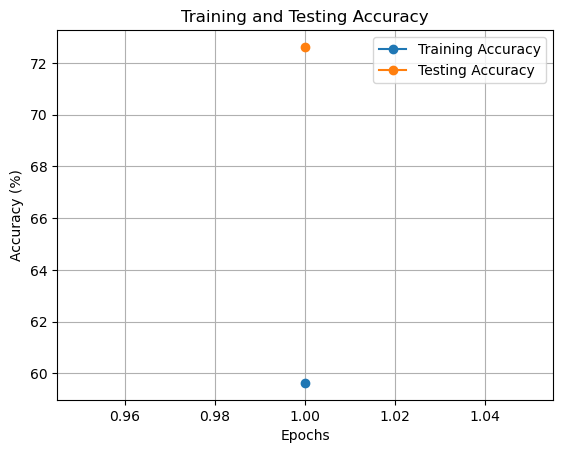

Epoch 2/10:
Train Loss: 0.5935, Train Acc: 68.71%
Test Loss: 0.5065, Test Acc: 76.96%
Best Test Acc: 76.96%
------------------------------------------------------------


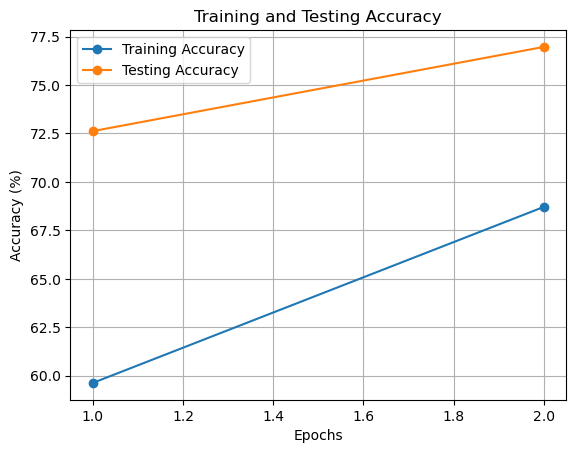

Epoch 3/10:
Train Loss: 0.5420, Train Acc: 73.17%
Test Loss: 0.4606, Test Acc: 78.90%
Best Test Acc: 78.90%
------------------------------------------------------------


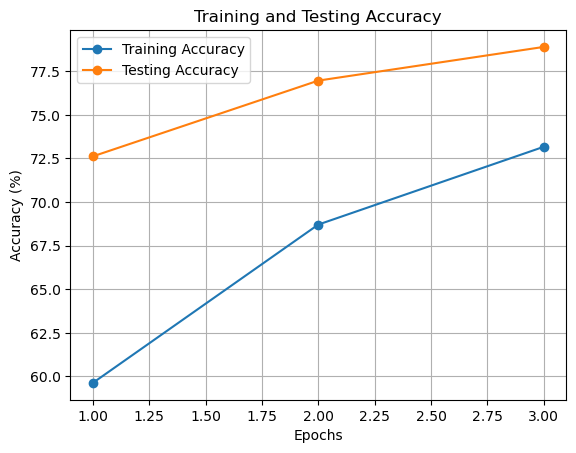

Epoch 4/10:
Train Loss: 0.4987, Train Acc: 76.09%
Test Loss: 0.4290, Test Acc: 80.50%
Best Test Acc: 80.50%
------------------------------------------------------------


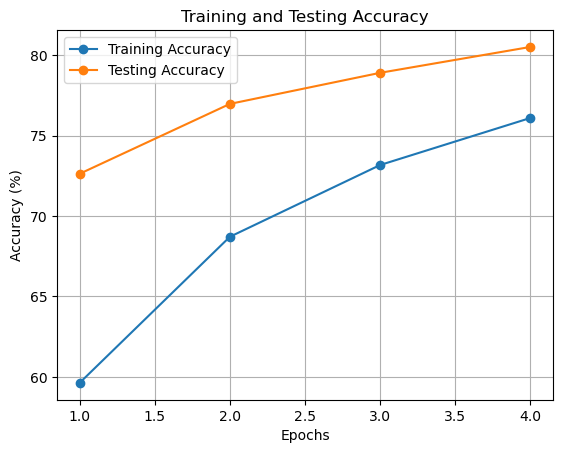

Epoch 5/10:
Train Loss: 0.4658, Train Acc: 78.55%
Test Loss: 0.4063, Test Acc: 81.90%
Best Test Acc: 81.90%
------------------------------------------------------------


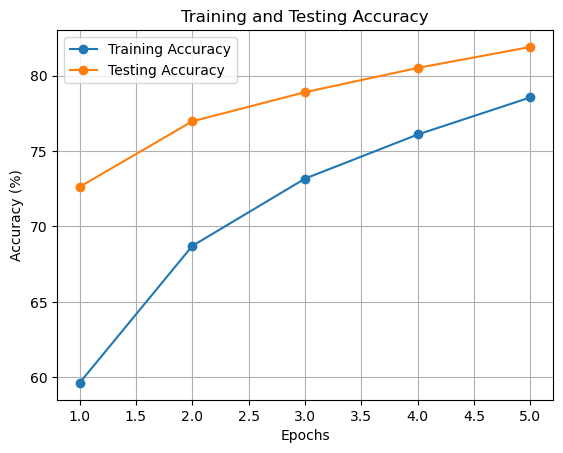

Epoch 6/10:
Train Loss: 0.4393, Train Acc: 80.17%
Test Loss: 0.3848, Test Acc: 82.96%
Best Test Acc: 82.96%
------------------------------------------------------------


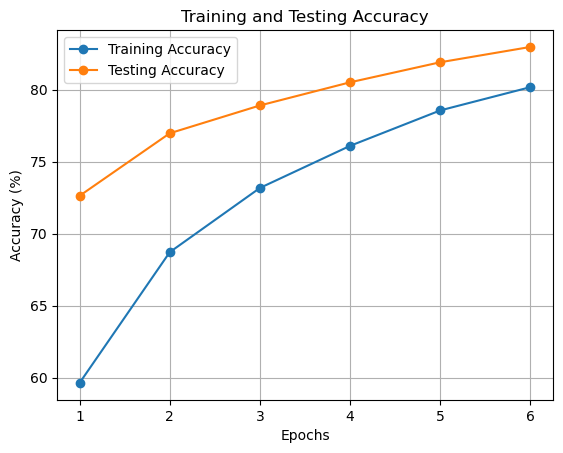

Epoch 7/10:
Train Loss: 0.4192, Train Acc: 81.15%
Test Loss: 0.3736, Test Acc: 83.65%
Best Test Acc: 83.65%
------------------------------------------------------------


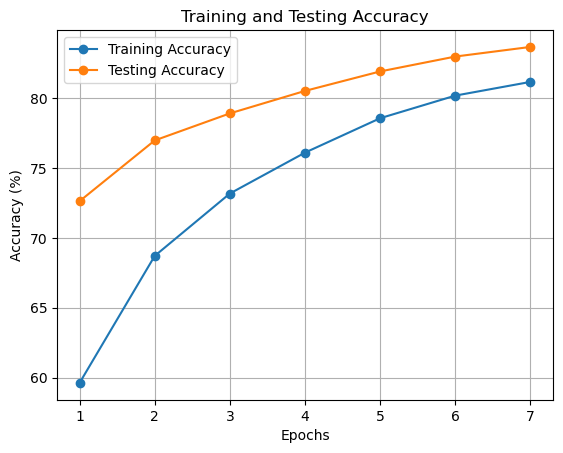

Epoch 8/10:
Train Loss: 0.3980, Train Acc: 82.52%
Test Loss: 0.3667, Test Acc: 84.16%
Best Test Acc: 84.16%
------------------------------------------------------------


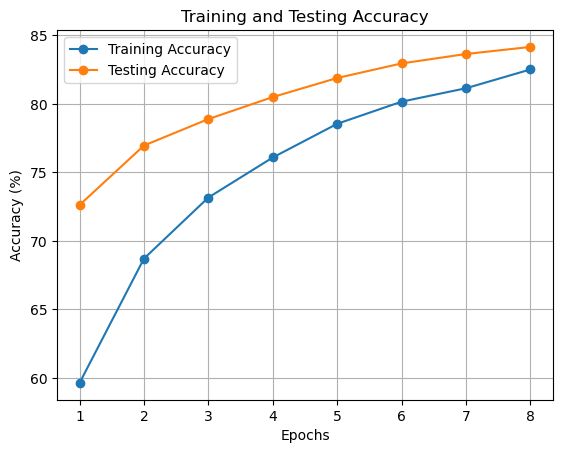

Epoch 9/10:
Train Loss: 0.3765, Train Acc: 83.72%
Test Loss: 0.3584, Test Acc: 84.37%
Best Test Acc: 84.37%
------------------------------------------------------------


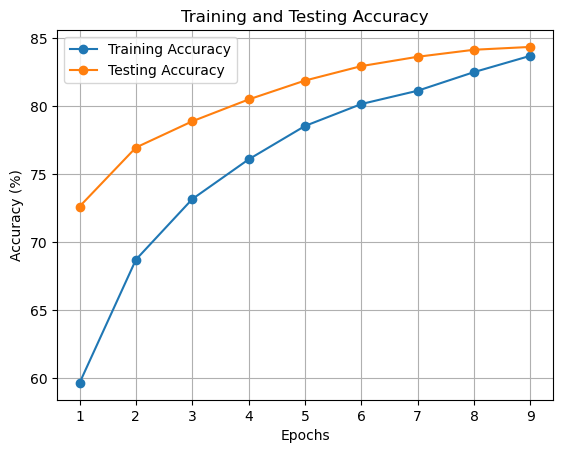

Epoch 10/10:
Train Loss: 0.3591, Train Acc: 84.70%
Test Loss: 0.3549, Test Acc: 84.70%
Best Test Acc: 84.70%
------------------------------------------------------------


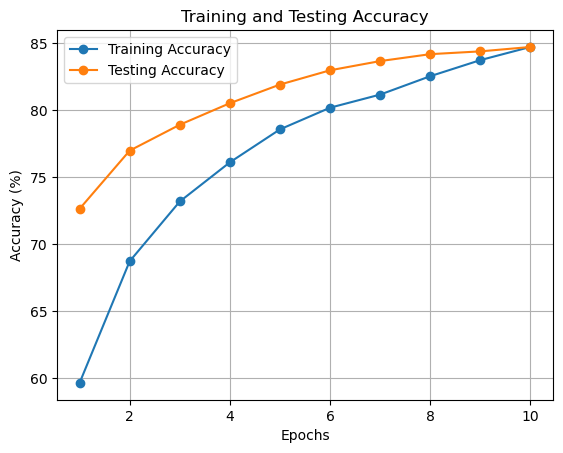

In [144]:
conv_config = {'num_channels': 50, 'kernel_sizes': [1, 2, 3]}
output_size = 2
learning_rate = 0.001
dropout = 0.8
embedding_dim = 128
batch_size = 64
vocab_size = len(vocab) + 1  
num_epochs = 10
train_labels = df_train['label'].values
test_labels = df_test['label'].values

train_dataset = SentimentDataset(train_padded, train_labels)
test_dataset = SentimentDataset(test_padded, test_labels)
                                
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

CUDA = torch.cuda.is_available()

model = TextCNN(vocab_size, embedding_dim, conv_config, output_size, dropout)

if CUDA:
    model = model.cuda()




#comparing train loss and test loss
criterion = nn.CrossEntropyLoss()
#setup parameters & weight decay
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs)


In [155]:
review = ["This movie is a gem that reminds us why we love cinema. From the very first scene, it pulls you into a vivid world of compelling characters, breathtaking visuals, and a narrative that keeps you emotionally invested until the very last frame. \
The performances are nothing short of extraordinary. The lead actor delivers a career-defining role, capturing every nuance of the character's journey. The supporting cast is equally remarkable, creating a dynamic ensemble that feels authentic and relatable. \
The director's vision is evident in every scene, blending artistry and storytelling in a way that feels seamless. The cinematography is stunning, with each frame looking like a carefully crafted painting. The music score adds another layer of depth, perfectly \
complementing the emotional highs and lows of the story. What truly sets this movie apart is its heart. It's a film that resonates on a deeply personal level, leaving you with a sense of hope, wonder, and inspiration. Whether you're a fan of heartfelt dramas, \
epic romances, or thought-provoking narratives, this film has something for everyone. A must-watch for anyone who loves great storytelling, this movie will stay with you long after the credits roll.", 
"This movie is a huge disappointment that fails to live up to \
its promises. From the very first scene, it struggles to capture your attention and quickly becomes tedious. The characters are bland and uninteresting, with performances that lack depth. The plot is predictable and meanders aimlessly, never building any real tension or \
excitement. The director's vision is absent, and the cinematography feels lazy and uninspired. The music score is generic and adds nothing to the story. Overall, it's a film that fails to connect on any meaningful level, leaving you feeling empty and unsatisfied. \
A total miss for anyone expecting a compelling cinematic experience.",
"I hate this movie so much, this movie is very good at being boring and slow",
"This is a beautifully written movie!",
"This movie is an absolute masterpiece, delivering a cinematic experience that is both deeply moving and visually stunning. From the very first scene, it captivates the audience with its rich storytelling and compelling characters. The performances are nothing short of spectacular, with the cast delivering their roles with remarkable depth and authenticity. The lead actor gives a tour-de-force performance, showcasing an impressive range of emotions that make their character unforgettable. \
The director's vision is evident in every frame, crafting a story that is as thought-provoking as it is emotionally resonant. The cinematography is breathtaking, with beautifully composed shots that feel like works of art. The musical score is equally powerful, perfectly complementing the highs and lows of the narrative and drawing the audience even deeper into the story. \
What sets this film apart is its ability to balance grand, epic storytelling with intimate, personal moments that strike a universal chord. It's a rare gem that combines artistry and entertainment, leaving you with a sense of awe and inspiration. This is a movie that will stay with you long after the credits roll, reminding you of the magic of great cinema. Truly a must-watch for film lovers everywhere!",
"This movie is a complete letdown, failing to deliver on even the most basic expectations of a good film. The story is uninspired and painfully predictable, offering no surprises or moments of genuine intrigue. The characters are one-dimensional, making it impossible to care about their journeys or outcomes. \
The performances feel flat and lack any emotional depth, as though the cast themselves weren't invested in the material. The direction is sloppy, with disjointed pacing that makes the film drag unbearably. Visually, the cinematography is bland and uninspired, lacking creativity or style. The musical score does little to enhance the experience, feeling generic and forgettable. \
Overall, this movie is an exercise in mediocrity, leaving no lasting impression other than frustration. It's a soulless production that feels more like a chore than entertainment. A complete waste of time for anyone seeking a compelling or enjoyable cinematic experience."]



'''
Test case
'''
df = pd.DataFrame(review, columns=['review'])

df['tokenized_review'] = tokenize_with_vocab(df['review'],vocab)
print(df['tokenized_review'])
df['review_ids'] = df['tokenized_review'].apply(lambda tokens: tokenize_id(tokens,vocab))
df['review_length'] = df['tokenized_review'].apply(len)
sequence_df = [torch.tensor(ids, dtype=torch.long) for ids in df['review_ids']]
max_length = int(df['review_length'].max())
padded = pad_sequences(sequence_df, max_length)

model.eval()
with torch.no_grad():
    output = model(padded)
    
    predicted_class = torch.argmax(output, dim=1).tolist()  

label_map = {0: "Negative Review", 1: "Positive Review"}
predicted_labels = [label_map[p] for p in predicted_class]

for i, review in enumerate(review):
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {predicted_labels[i]}\n")
probabilities = torch.softmax(output, dim=1)
for i, prob in enumerate(probabilities):
    if prob[0] > prob[1]:  
        sentiment = "Negative Review"
    else:
        sentiment = "Positive Review"
    print(f"Review {i + 1}: {sentiment} (Confidence: {prob.max().item():.2f})")


0    [gem, remind, love, cinema, scene, pull, vivid...
1    [huge, disappointment, fail, live, promise, sc...
2                           [hate, good, boring, slow]
3                                 [beautifully, write]
4    [absolute, masterpiece, deliver, cinematic, ex...
5    [complete, letdown, fail, deliver, basic, expe...
Name: tokenized_review, dtype: object
Review: This movie is a gem that reminds us why we love cinema. From the very first scene, it pulls you into a vivid world of compelling characters, breathtaking visuals, and a narrative that keeps you emotionally invested until the very last frame. The performances are nothing short of extraordinary. The lead actor delivers a career-defining role, capturing every nuance of the character's journey. The supporting cast is equally remarkable, creating a dynamic ensemble that feels authentic and relatable. The director's vision is evident in every scene, blending artistry and storytelling in a way that feels seamless. The cinem

/opt/anaconda3/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
